In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Glaucoma/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train"
TEST_DIR = "/content/drive/MyDrive/Glaucoma/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation"

In [ ]:
HEIGHT = 255
WIDTH = 255

In [ ]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (HEIGHT, WIDTH, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 261, 261, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
for layer in basemodel.layers[:-10]:
    layer.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(2,2))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(1024, activation = 'relu')(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(512, activation = 'relu')(headmodel)
headmodel = Dropout(0.35)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input , outputs = headmodel)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss='binary_crossentropy', metrics=['accuracy'] )

In [ ]:
tgen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)
vgen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

In [ ]:
train_generator = tgen.flow_from_directory(batch_size=4, directory = TRAIN_DIR, shuffle = True, target_size=(HEIGHT, WIDTH))
val_generator = vgen.flow_from_directory(batch_size=4, directory = TEST_DIR, shuffle = True, target_size=(HEIGHT, WIDTH))

Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 200, 
                            validation_data = val_generator, validation_steps = val_generator.n // 4,
                            callbacks = [checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
130/130 [==============================] - 356s 3s/step - loss: 1.5494 - accuracy: 0.6558 - val_loss: 0.6785 - val_accuracy: 0.5781

Epoch 00001: val_loss improved from inf to 0.67853, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
130/130 [==============================] - 352s 3s/step - loss: 0.7622 - accuracy: 0.6712 - val_loss: 0.5780 - val_accuracy: 0.7344

Epoch 00002: val_loss improved from 0.67853 to 0.57799, saving model to weights.hdf5
Epoch 3/200
130/130 [==============================] - 307s 2s/step - loss: 0.6957 - accuracy: 0.6846 - val_loss: 0.5913 - val_accuracy: 0.7188

Epoch 00003: val_loss did not improve from 0.57799
Epoch 4/200
130/130 [==============================] - 426s 3s/step - loss: 0.6185 - accuracy: 0.6981 - val_loss: 0.5716 - val_accuracy: 0.6719

Epoch 00004: val_loss improved from 0.57799 to 0.57161, saving model to weights.hdf5
Epoch 5/200
130/130 [==============================] - 542s 4s/step - loss: 0.5835 - accuracy: 0.7154 - val_loss: 0.5529 - val_accuracy: 0.6953

Epoch 00005: val_loss improved from 0.57161 to 0.55289, saving model to weights.hdf5
Epoch 6/200
130/130 [==============================] - 332s 3s/step - loss: 0.5873 - accuracy: 0.7269 - val_loss: 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

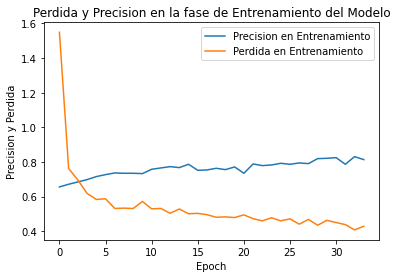

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

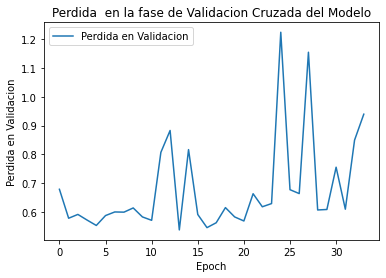

In [ ]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

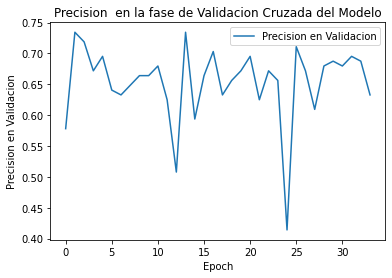

In [ ]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [ ]:
test_directory = "/content/drive/MyDrive/test"

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=4, directory = TEST_DIR, shuffle = True, target_size=(HEIGHT, WIDTH))

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

NameError: ignored

**MATRIZ DE CONFUSION**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        print(item)
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (HEIGHT,WIDTH))
        image.append(img)
        img = img/255
        img = img.reshape(-1, HEIGHT, WIDTH, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)
        

FileNotFoundError: ignored

In [ ]:
os.chdir("/content/drive/My Drive/test")
!ls

In [ ]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)